In [0]:
!pip install fastai==0.7.0
!pip install Pillow==4.1.1
!pip install torchtext==0.2.3

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.learner import *
from fastai.column_data import *

In [0]:
!mkdir data/
!wget http://files.grouplens.org/datasets/movielens/ml-latest-small.zip 
!unzip ml-latest-small.zip -d data/

In [0]:
path = "data/ml-latest-small/"

In [5]:
!ls {path}

links.csv  movies.csv  ratings.csv  README.txt	tags.csv


### this method is called probabilistic matrix factorization 
### if we create sparse matrix then there are huge number of movies we havent seen so they are rated 0 and hurt the values so using it in tabular form will be good

In [6]:
movies = pd.read_csv(f'{path}/movies.csv')
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [7]:
ratings= pd.read_csv(f'{path}/ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [8]:
# showing in terms of excel not necessary in any manner for training
g=ratings.groupby('userId')['rating'].count()
topUsers=g.sort_values(ascending=False)[:15]

g=ratings.groupby('movieId')['rating'].count()
topMovies=g.sort_values(ascending=False)[:15]

top_r = ratings.join(topUsers, rsuffix='_r', how='inner', on='userId')
top_r = top_r.join(topMovies, rsuffix='_r', how='inner', on='movieId')

pd.crosstab(top_r.userId, top_r.movieId, top_r.rating, aggfunc=np.sum)

movieId,1,50,110,260,296,318,356,480,527,589,593,1196,2571,2858,2959
userId,,,,,,,,,,,,,,,
68,2.5,3.0,2.5,5.0,2.0,3.0,3.5,3.5,4.0,3.5,3.5,5.0,4.5,5.0,2.5
182,4.0,4.5,3.5,3.5,5.0,4.5,5.0,3.5,4.0,2.0,4.5,3.0,5.0,5.0,5.0
249,4.0,4.0,5.0,5.0,4.0,4.5,4.5,4.0,4.5,4.0,4.0,5.0,5.0,4.5,5.0
274,4.0,4.0,4.5,3.0,5.0,4.5,4.5,3.5,4.0,4.5,4.0,4.5,4.0,5.0,5.0
288,4.5,NaN,5.0,5.0,5.0,5.0,5.0,2.0,5.0,4.0,5.0,4.5,3.0,NaN,3.5
307,4.0,4.5,3.5,3.5,4.5,4.5,4.0,3.5,4.5,2.5,4.5,3.0,3.5,4.0,4.0
380,5.0,4.0,4.0,5.0,5.0,3.0,5.0,5.0,NaN,5.0,5.0,5.0,4.5,NaN,4.0
387,NaN,4.5,3.5,4.5,5.0,3.5,4.0,3.0,NaN,3.5,4.0,4.5,4.0,4.5,4.5
414,4.0,5.0,5.0,5.0,5.0,5.0,5.0,4.0,4.0,5.0,4.0,5.0,5.0,5.0,5.0


In [0]:
# using cross validation indices
val_idxs = get_cv_idxs(len(ratings))
wd  =2e-4 # weight decay we using l2 regularization
n_factors = 50 # embedding matrix size

In [0]:
# now declaring data -- collaborativeFilterData
cf = CollabFilterDataset.from_csv(path,'ratings.csv','userId','movieId','rating')
learn = cf.get_learner(n_factors, val_idxs, 64, opt_fn=optim.Adam)

In [11]:
learn.lr_find()

 72%|███████▏  | 907/1261 [00:07<00:02, 127.50it/s, loss=4.45]


In [0]:
learn.sched.plot_lr()

In [13]:
learn.fit(1e-2,2,wds = wd,cycle_len =1,cycle_mult=2)

epoch      trn_loss   val_loss   
    0      0.745924   0.771416  
    1      0.736296   0.756447  
    2      0.572652   0.739107  



[array([0.73911])]

In [14]:
math.sqrt(0.7379) # finding loss smaller the better
# standard value was 0.91

0.8590110593001699

In [0]:
#predictions
preds = learn.predict()

In [0]:
%matplotlib inline   
# necessary for plotting

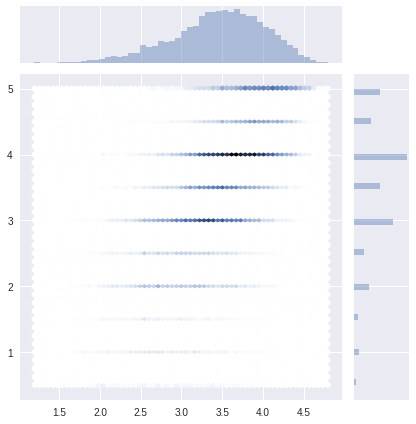

In [18]:
# using seaborn to plot stuff
y=learn.data.val_y
sns.jointplot(preds, y, kind='hex', stat_func=None);

### now since we have to do dotproduct of those embedding matrices we get index of each movie and it's 50 ratings since there is 50 depth in emb matrix and then we take each user and take it's 50 ratings and dot product them

## building our own layer / neural network


In [0]:
class DotProduct(nn.Module):
  def forward(self,u,m): return (u*m).sum(1)

In [20]:
model = DotProduct()
model()

TypeError: ignored

### advanced network creating our model from scratch


In [0]:
## just making embedding matrices with unique values

# first have to make a dictionary of all the unique items with unique integer
u_uniq = ratings.userId.unique() 
user2idx = {o:i for i,o in enumerate(u_uniq)} # here made dict  ### imp
ratings.userId = ratings.userId.apply(lambda x: user2idx[x])  # replace userId with that values

m_uniq = ratings.movieId.unique() 
movie2idx = {o:i for i,o in enumerate(m_uniq)} 
ratings.movieId = ratings.movieId.apply(lambda x: movie2idx[x])  

n_users=int(ratings.userId.nunique())
n_movies=int(ratings.movieId.nunique())

In [0]:
# we are creating our own model for the fitting as we need to do dot product of embeddings (from scratch for fun)
# this is the model

class EmbeddingDot(nn.Module):
  def __init__(self,n_users,n_movies):
    super().__init__()
    self.u = nn.Embedding(n_users, n_factors) # this embedding is a variable saves states of all the changes done
    self.m = nn.Embedding(n_movies, n_factors)  
    self.u.weight.data.uniform_(0,0.05) # initialize numbers b/w 0 and 0.05 # underscore means doitinplace otherwise it will return value
    self.m.weight.data.uniform_(0,0.05) # .weight contains actual embedding matrix which is a var
  
  def forward(self, cats, conts): # categorical var and continuous variables
        users,movies = cats[:,0],cats[:,1] # will give mini batch not single value
        u,m = self.u(users),self.m(movies)  # look up our mini batches(users and movies) in embedding matrices u and m
        return (u*m).sum(1)  
      
      
 ## dont loop use mini batches as done above     

In [0]:
x = ratings.drop(['rating', 'timestamp'],axis=1)
y = ratings['rating'].astype(np.float32)

In [0]:
# since we are using columnarModelData class which uses categorical and continuous var we defined cat and conts 
# we dont have continuous variables

data = ColumnarModelData.from_data_frame(path,val_idxs,x,y,['userId','movieId'],64)

# data.ColumnarModelData takes a Pandas DataFrame as input and creates a type of ModelData object (an object which contains data loaders for 
# the training, validation, and test sets, and which is the fundamental way of keeping track of your data while training models).



In [0]:
wd=1e-5
model = EmbeddingDot(n_users, n_movies).cuda()
opt = optim.SGD(model.parameters(), 1e-1, weight_decay=wd, momentum=0.9) # model.parameters are the weights optimizer optimizes them # also given learning rate

In [26]:
# creating training loop
# a fastai function
fit(model, data, 3, opt, F.mse_loss)
# not gonna get differential learning rate or stoch grad desc


epoch      trn_loss   val_loss   
    0      1.617911   1.597916  
    1      1.060549   1.298891  
    2      0.859028   1.235227  



[array([1.23523])]

In [0]:
# here since the loss is quite high compared to our high level implementation so we do learning rate annealing also
set_lrs(opt,0.01)

In [28]:
fit(model,data,3,opt,F.mse_loss) 
# F is a PyTorch functional (torch.nn.functional) that contains all functions for tensors, and is imported as F in most cases.

epoch      trn_loss   val_loss   
    0      0.698017   1.154647  
    1      0.679851   1.143318  
    2      0.666274   1.136598  



[array([1.1366])]

## continuing high level implementation

In [0]:
# there is a bias in people's choices and some movies are good : so we use bias
# define minimum and max ratings

min_rating,max_rating = ratings.rating.min(), ratings.rating.min()  # just finding min and max rating val



In [0]:
def get_emb(ni,nf): # no. of inputs and no. of factors no of rows and cols
  e = nn.Embedding(ni,nf)
  e.weight.data.uniform_(-0.01,0.01) # randomly init embedding
  return e

class EmbeddingDotBias(nn.Module):
    def __init__(self, n_users, n_movies):
        super().__init__()
        (self.u, self.m, self.ub, self.mb) = [get_emb(*o) for o in [
            (n_users, n_factors), (n_movies, n_factors), (n_users,1), (n_movies,1)
        ]]
        
    def forward(self, cats, conts):
        users,movies = cats[:,0],cats[:,1]
        um = (self.u(users)* self.m(movies)).sum(1)
        res = um + self.ub(users).squeeze() + self.mb(movies).squeeze()  # broadcasting using squeeze
        res = F.sigmoid(res) * (max_rating-min_rating) + min_rating
        return res.view(-1, 1)

to make rating b/w 1 and 5 :: input to sigmoid function mult rating by 4 and add 1

In [31]:
wd=2e-4
model = EmbeddingDotBias(cf.n_users, cf.n_items).cuda()
opt = optim.SGD(model.parameters(), 1e-1, weight_decay=wd, momentum=0.9)
fit(model, data, 3, opt, F.mse_loss)

epoch      trn_loss   val_loss   
    0      10.096692  10.085213 
    1      10.089713  10.085213 
    2      10.019439  10.085213 



[array([10.08521])]

## creating neural n/w implementation
<img src ="https://cdn-images-1.medium.com/max/1000/1*0CRZIBnNzw1lT_9EHOyd5g.png">

Rather than calculating the dot product of user embedding vector and movie embedding vector to get a prediction, we will concatenate the two and feed it through neural net.

each user gets contiguous numbers just like mapping e.g user_id 14 will be user 1 [] 29 will be 2

In [0]:
# nn.linear already has a bias take single user and single movie concat them and matrix pro there can be any no of cols and no. of rows = no of users + no. of movies
class EmbeddingNet(nn.Module):
    def __init__(self, n_users, n_movies, nh=10, p1=0.5, p2=0.5):
        super().__init__()
        (self.u, self.m) = [get_emb(*o) for o in [
            (n_users, n_factors), (n_movies, n_factors)]]
        self.lin1 = nn.Linear(n_factors*2, nh)
        self.lin2 = nn.Linear(nh, 1)
        self.drop1 = nn.Dropout(p1)
        self.drop2 = nn.Dropout(p2)
        
    def forward(self, cats, conts):
        users,movies = cats[:,0],cats[:,1]
        x = self.drop1(torch.cat([self.u(users),self.m(movies)], dim=1)) # colms are concatenated
        x = self.drop2(F.relu(self.lin1(x)))    # going through linear and then relu
        return F.sigmoid(self.lin2(x)) * (max_rating-min_rating+1) + min_rating-0.5

In [0]:
wd=1e-5
model = EmbeddingNet(n_users, n_movies).cuda()
opt = optim.Adam(model.parameters(), 1e-3, weight_decay=wd)


In [37]:
fit(model, data, 3, opt, F.mse_loss)

epoch      trn_loss   val_loss   
    0      7.636182   7.338122  
    1      7.432188   7.337706  
    2      7.383425   7.337698  



[array([7.3377])]